In [2]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from IPython.core.display_functions import display
from biogeme.expressions import Beta, Variable
from biogeme.models import loglogit
from biogeme.segmentation import DiscreteSegmentationTuple, segmented_beta

In [3]:
data = pd.read_csv("lpmc01.dat", sep = '\t')

# Step 1: Identify whether each household has a driving license
data['household_has_license'] = data.groupby('household_id')['driving_license'].transform(lambda x: x.max())

# Step 2: Define a filter for the availability conditions not being met
car_availability_unmet = (data['car_ownership'] == 0) & (data['driving_license'] == 0) & (data['household_has_license'] == 0)

# Step 3: Identify rows where travel_mode is 4 (car) but the availability conditions are not met
car_without_availability = data[(data['travel_mode'] == 4) & car_availability_unmet]

# Step 4: Remove those rows from the original DataFrame
data_filtered = data[~data.index.isin(car_without_availability.index)]

database = db.Database('london', data_filtered)

In [4]:
data_filtered.describe()

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent,household_has_license
count,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,...,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000
mean,40237.209472,8643.030763,0.773932,1.538353,3.047359,2.888687,2.780814,2.205829,0.662619,1.974094,...,0.091402,0.172350,0.044814,0.371180,0.284220,1.599806,0.837735,1.145416,0.336556,0.689334
std,23379.474440,5064.169881,1.027603,1.768024,1.081396,1.188233,2.218510,1.720187,0.466398,0.816912,...,0.175669,0.190150,0.078959,0.623633,0.253322,1.525741,0.821638,3.273692,0.200867,0.462813
min,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.009722,0.000000,0.030000,0.000000,0.000000,0.000000
25%,19903.000000,4214.000000,0.000000,0.000000,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.035833,0.000000,0.000000,0.107500,0.000000,0.280000,0.000000,0.172973,0.000000
50%,40280.000000,8615.000000,0.000000,1.000000,3.000000,3.000000,2.000000,1.000000,1.000000,2.000000,...,0.000000,0.111111,0.000000,0.000000,0.189167,1.500000,0.540000,0.000000,0.304348,1.000000
75%,60195.000000,12907.000000,1.000000,2.000000,4.000000,3.000000,6.000000,4.000000,1.000000,3.000000,...,0.100000,0.250000,0.091667,1.000000,0.378056,2.400000,1.120000,0.000000,0.488011,1.000000
max,81084.000000,17615.000000,7.000000,14.000000,4.000000,5.000000,6.000000,5.000000,1.000000,3.000000,...,1.183333,1.871944,0.750000,4.000000,1.730556,10.600000,8.630000,10.500000,0.957627,1.000000


In [5]:
pt_data = data_filtered[data_filtered['travel_mode'] == 3]

pt_data[['cost_transit', 'faretype', 'bus_scale']].describe()

,cost_transit,faretype,bus_scale
count,1766.000000,1766.000000,1766.000000
mean,1.947571,2.270102,0.636183
std,1.853382,1.710186,0.471270
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,1.500000,1.000000,1.000000
75%,3.000000,4.000000,1.000000
max,10.100000,5.000000,1.000000


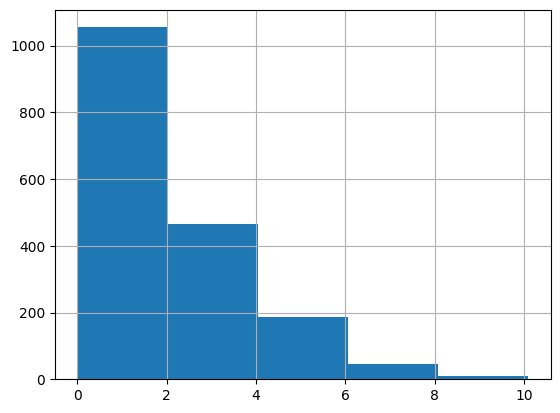

In [6]:
hist = pt_data['cost_transit'].hist(bins=5)

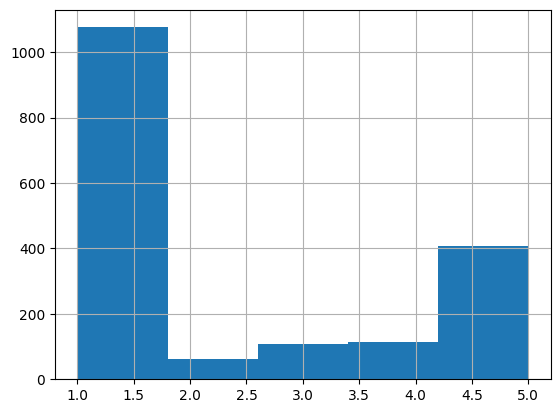

In [7]:
hist = pt_data['faretype'].hist(bins=5)


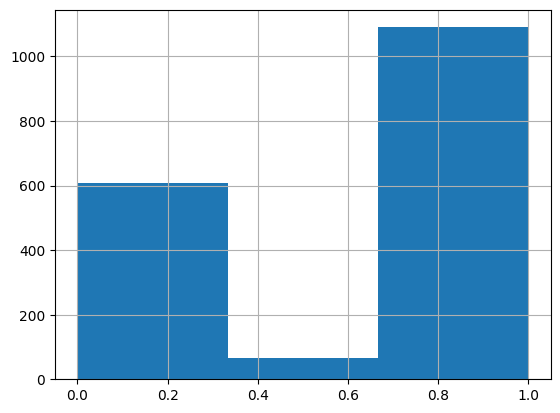

In [8]:
hist = pt_data['bus_scale'].hist(bins=3)

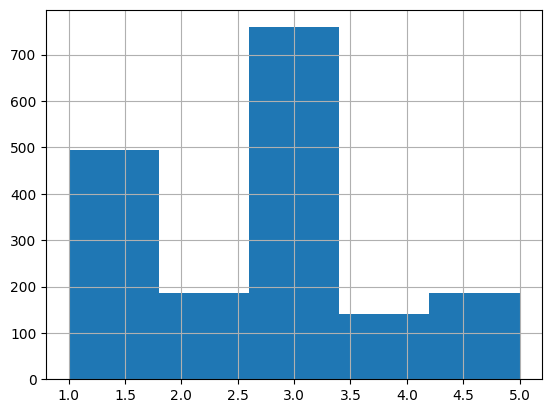

In [9]:
hist = pt_data['purpose'].hist(bins=5)

In [10]:
nonpt_data = data_filtered[data_filtered['travel_mode'] != 3]

nonpt_data[['cost_transit', 'faretype', 'bus_scale']].describe()

,cost_transit,faretype,bus_scale
count,3175.000000,3175.000000,3175.000000
mean,1.406372,2.170079,0.677323
std,1.268164,1.724957,0.463088
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,1.500000,1.000000,1.000000
75%,1.500000,4.000000,1.000000
max,10.600000,5.000000,1.000000


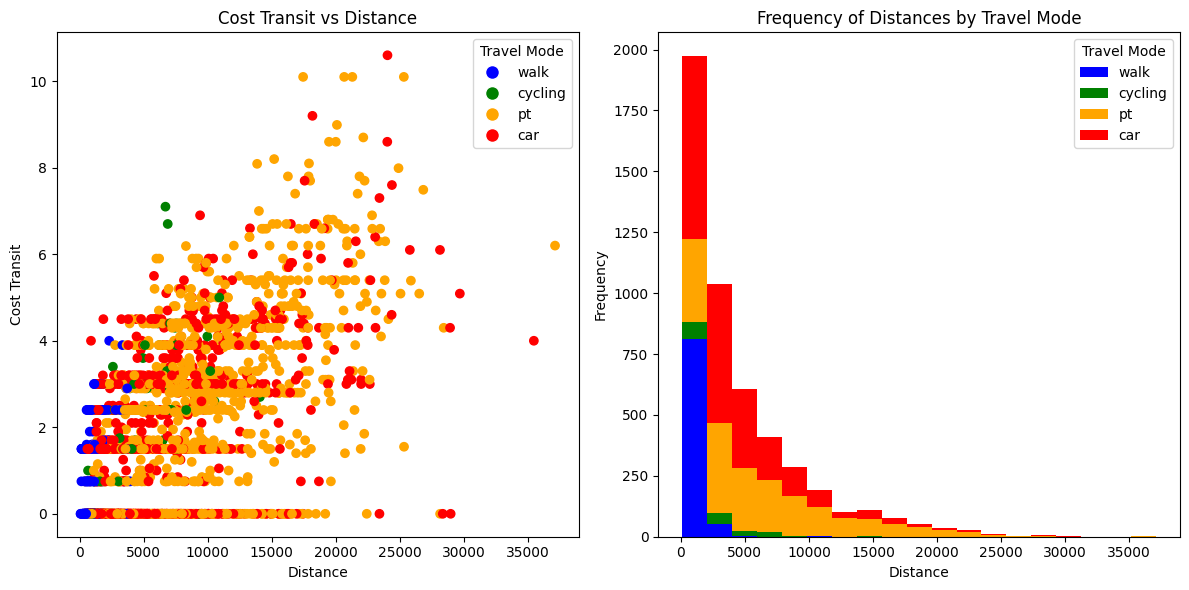

In [23]:
distance = data_filtered['distance']
cost_transit = data_filtered['cost_transit']
choice = data_filtered['travel_mode']
choices = ['walk', 'cycling', 'pt', 'car']

import matplotlib.pyplot as plt
import numpy as np

# Define colors for each choice (1, 2, 3, 4)
color_map = {1: 'blue', 2: 'green', 3: 'orange', 4: 'red'}
labels = {1: 'walk', 2: 'cycling', 3: 'pt', 4: 'car'}

# Separate distances by travel mode
distance_by_mode = {mode: distance[choice == mode] for mode in color_map}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot with color based on choice
colors = [color_map[c] for c in choice]
axes[0].scatter(distance, cost_transit, c=colors)
axes[0].set_title("Cost Transit vs Distance")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Cost Transit")

# Create custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[i], markersize=10, label=labels[i]) for i in color_map]
axes[0].legend(handles=legend_elements, title="Travel Mode")

# Stacked histogram for travel modes
bins = np.linspace(min(distance), max(distance), 20)
hist_data = [distance_by_mode[mode] for mode in color_map]
axes[1].hist(hist_data, bins=bins, stacked=True, color=[color_map[i] for i in color_map], label=[labels[i] for i in color_map])

axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Frequency of Distances by Travel Mode")
axes[1].legend(title="Travel Mode")

plt.tight_layout()
plt.show()


In [28]:
walk_max_distance = distance[choice == 1].max()
walk_avg_distance = distance[choice == 1].mean()
cycling_max_distance = distance[choice == 2].max()
cycling_avg_distance = distance[choice == 2].mean()


print(f"Max distance for walking: {walk_max_distance}")
print(f"Average distance for walking: {walk_avg_distance:.1f}")
print(f"Max distance for cycling: {cycling_max_distance}")
print(f"Average distance for cycling: {cycling_avg_distance:.1f}")


Max distance for walking: 9999
Average distance for walking: 1023.4
Max distance for cycling: 14079
Average distance for cycling: 3243.2


## Variable Definition

In [197]:
trip_id = Variable('trip_id')
household_id = Variable('household_id')
person_n = Variable('person_n')
trip_n = Variable('trip_n')
travel_mode = Variable('travel_mode')
purpose = Variable('purpose')
fueltype = Variable('fueltype')
faretype = Variable('faretype')
bus_scale = Variable('bus_scale')
survey_year = Variable('survey_year')
travel_year = Variable('travel_year')
travel_month = Variable('travel_month')
travel_date = Variable('travel_date')
day_of_week = Variable('day_of_week')
start_time = Variable('start_time')
age = Variable('age')
female = Variable('female')
driving_license = Variable('driving_license')
car_ownership = Variable('car_ownership')
distance = Variable('distance')
dur_walking = Variable('dur_walking')
dur_cycling = Variable('dur_cycling')
dur_pt_access = Variable('dur_pt_access') # Predicted total access and egress time for public transport route in hours
dur_pt_rail = Variable('dur_pt_rail')
dur_pt_bus = Variable('dur_pt_bus')
dur_pt_int = Variable('dur_pt_int') # Time taken (hrs) at each interchange point
pt_interchanges = Variable('pt_interchanges')   # Number of interchange points in public transport route
dur_driving = Variable('dur_driving')
cost_transit = Variable('cost_transit')
cost_driving_fuel = Variable('cost_driving_fuel')   # Estimated fuel cost of driving route in GBP
cost_driving_ccharge = Variable('cost_driving_ccharge')  # Estimated congestion charge cost of driving route in GBP
driving_traffic_percent = Variable('driving_traffic_percent')

household_has_license = Variable('household_has_license')


In [198]:
# Define driving cost
cost_driving = cost_driving_ccharge + cost_driving_fuel

# Define time taken by each mode of transport
time_pt = dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int 

time_cycling = dur_cycling
time_walking = dur_walking
time_driving = dur_driving

# Model 0

In [199]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_cost = Beta(name='beta_cost', value=0, lowerbound=None, upperbound=None, status=0)
beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)


In [200]:
# Define utility functions

v_car = asc_car + beta_cost * cost_driving + beta_time * time_driving

v_walk = asc_walk + beta_time * time_walking

v_pt = asc_pt + beta_cost * cost_transit + beta_time * time_pt

v_cycling = beta_time * time_cycling

In [201]:
V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [202]:
logprob = loglogit(V, av, travel_mode)

In [203]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'logit_london'


In [204]:
null_log_likelihood = biogeme.calculate_null_loglikelihood(av)
display(null_log_likelihood)


np.float64(-6610.328954013736)

In [205]:
results = biogeme.estimate()

In [206]:
print(results.print_general_statistics())

Number of estimated parameters:	5
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-4007.051
Final log likelihood:	-4007.051
Likelihood ratio test for the null model:	5206.557
Rho-square for the null model:	0.394
Rho-square-bar for the null model:	0.393
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00125
Akaike Information Criterion:	8024.101
Bayesian Information Criterion:	8056.628
Final gradient norm:	1.0674E-01
Nbr of threads:	16



In [207]:
pandas_results = results.get_estimated_parameters()
display(pandas_results)


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.903966,0.091312,31.802599,0.0
asc_pt,3.355050,0.094506,35.500775,0.0
asc_walk,3.944776,0.112852,34.955460,0.0
beta_cost,-0.206602,0.015113,-13.670502,0.0
beta_time,-5.973208,0.227260,-26.283589,0.0


# Model 1: Time alternative specific

In [208]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + beta_time * time_driving

v_walk = asc_walk + beta_time * time_walking

v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time * time_pt

v_cycling = beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

logprob_cS = loglogit(V, av, travel_mode)

biogeme_cS = bio.BIOGEME(database, logprob_cS)
biogeme_cS.modelName = 'logit_london_costSpecific'

null_log_likelihood_cS = biogeme_cS.calculate_null_loglikelihood(av)
display(null_log_likelihood_cS)


np.float64(-6610.328954013736)

In [209]:
results_cS = biogeme_cS.estimate()
print(results_cS.print_general_statistics())

Number of estimated parameters:	6
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3943.179
Final log likelihood:	-3943.179
Likelihood ratio test for the null model:	5334.3
Rho-square for the null model:	0.403
Rho-square-bar for the null model:	0.403
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00152
Akaike Information Criterion:	7898.358
Bayesian Information Criterion:	7937.39
Final gradient norm:	1.5702E-01
Nbr of threads:	16



In [210]:
pandas_results_cS = results_cS.get_estimated_parameters()
display(pandas_results_cS)


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.943827,0.089854,32.762397,0.000000
asc_pt,2.938973,0.101224,29.034305,0.000000
asc_walk,3.856666,0.112949,34.145138,0.000000
beta_cost_car,-0.264995,0.026482,-10.006711,0.000000
beta_cost_pt,0.050401,0.030429,1.656319,0.097657
beta_time,-5.934668,0.231000,-25.691239,0.000000
